# Project 4: Final Project - Random Acts of Pizza
### Predicting altruism through free pizza

This project is originated from the Kaggle competition https://www.kaggle.com/c/random-acts-of-pizza. We will create an algorithm to predict which requests will recieve pizza and which on will not.  The competition contains a dataset with 5671 textual requests for pizza from the Reddit community Random Acts of Pizza together with their outcome (successful/unsuccessful) and meta-data. This data was collected and graciously shared by Althoff et al (http://www.timalthoff.com/). 

**Reference Paper:**
Tim Althoff, Cristian Danescu-Niculescu-Mizil, Dan Jurafsky. How to Ask for a Favor: A Case Study on the Success of Altruistic Requests, Proceedings of ICWSM, 2014. (http://cs.stanford.edu/~althoff/raop-dataset/altruistic_requests_icwsm.pdf)


## Approach 


**Step 1:  Exploratory Data Analysis **

**Step 2:  Create a Baseline Model **

**Step 3:  Feature Engineering **

- Preprocessing data 
    - data cleansing 
    - data transformation

- Use other meta-data from the data set, such as,
    - request_text_edit_aware
    - request_title
    - requester_account_age_in_days_at_request
    - requester_days_since_first_post_on_raop_at_request
    - requester_number_of_comments_at_request
    - requester_number_of_comments_in_raop_at_request
    - requester_number_of_posts_at_request
    - requester_number_of_posts_on_raop_at_request
    - requester_number_of_subreddits_at_request
    - requester_subreddits_at_request
    - requester_upvotes_minus_downvotes_at_request
    - requester_upvotes_plus_downvotes_at_request
    - requester_username
    - unix_timestamp_of_request
    - unix_timestamp_of_request_utc
    - other features includes:
        - number of requests made by the same user
        - number of requests fulfilled or % of requests fulfilled, etc
    
- Generate new features from the data set such as, 
    - Politeness, 
    - Evidentiality, 
    - Reciprocity, 
    - Sentiment, 
    - Length, etc

**Step 4:  Algorithm / Model Selection **

- Generative Models 
    - Naive Bayes 
- Discriminative Models
    - Logistic Regression  
- Neural Network 


**Step 5:  Error Analysis & Optimization ** 


**Step 6:  Final Model ** 




## Load Data

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# SK-learn libraries for model selection 
from sklearn.model_selection import train_test_split

# json libraries to parse json file
import json
from pandas.io.json import json_normalize

/Users/gurditchahal/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/gurditchahal/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
# read json file
train_json = json.load(open('train.json'))

# normalize data and put in a dataframe
train_json_df = json_normalize(train_json)

# read json file
test_json = json.load(open('test.json'))

# normalize data and put in a dataframe
test_json_df = json_normalize(test_json)

print("Train shape: ", train_json_df.shape)
print("Test shape: ", test_json_df.shape)

Train shape:  (4040, 32)
Test shape:  (1631, 17)


The training data has 32 columns, while the test data only has 17. __Data providers have removed fields from the test set which would not be available at the time of posting.__

In [29]:
train_only_columns = set(train_json_df.columns.values)-set(test_json_df.columns.values)
print("Columns in Train but not Test:\n",train_only_columns)
test_only_columns = set(test_json_df.columns.values)-set(train_json_df.columns.values)
print("\nColumns in Test but not Train:",test_only_columns)

Columns in Train but not Test:
 {'request_text', 'requester_account_age_in_days_at_retrieval', 'requester_upvotes_plus_downvotes_at_retrieval', 'requester_number_of_posts_on_raop_at_retrieval', 'number_of_upvotes_of_request_at_retrieval', 'requester_number_of_comments_in_raop_at_retrieval', 'requester_number_of_posts_at_retrieval', 'requester_user_flair', 'post_was_edited', 'request_number_of_comments_at_retrieval', 'requester_received_pizza', 'requester_upvotes_minus_downvotes_at_retrieval', 'number_of_downvotes_of_request_at_retrieval', 'requester_number_of_comments_at_retrieval', 'requester_days_since_first_post_on_raop_at_retrieval'}

Columns in Test but not Train: set()


The columns that are in the training data but not the test data need to be excluded. Let's take a closer look at the significance of these columns.

- request_text: Since posts are often edited after a successful request, this request_text column is not the most accurate. Instead, request_text_edit_aware, which is available in both the train and test sets, will be used. This edit aware version of "request_text" strips edited comments indicating the success of the request.
- _at_retrieval: For our purposes of real-time prediction, _at_request columns are more relevant.
- post_was_edited: 
- requester_user_flair: This is a post-receipt of pizza feature and thus will not be a useful indicator of results.
- requester_received_pizza:

In [43]:
# Create a test dataframe with only the mathcing train columns
test_w_train_col = train_json_df[test_json_df.columns.values]

In [30]:
# Check to see that dataset is balanced in number of request success and failures
print(train_json_df['requester_received_pizza'].value_counts())
print("Percentage of request failures: " + str(round(3046/len(train_json_df),2)*100)+"%.")
print("Percentage of request failures: " + str(round(994/len(train_json_df),2)*100)+"%.")

False    3046
True      994
Name: requester_received_pizza, dtype: int64
Percentage of request failures: 75.0%.
Percentage of request failures: 25.0%.


We should consider balancing our features to that it's closer to 50-50. To do this we can try duplicating our successes.

In [4]:
# for the baseline, we just use the "request_text_edit_aware" as input features 
# but we can explore other metadata (such as "request_title", 
# "number_of_downvotes_of_request_at_retrieval", "number_of_upvotes_of_request_at_retrieval", etc) 
# to add to the input features 
train_data = train_json_df.request_text_edit_aware.as_matrix()

# convert the requester_received_pizza field to 0 and 1
# 0 means the user doesn't receive pizza & 1 means the user receives pizza
train_labels = train_json_df.requester_received_pizza.astype(int).as_matrix()

# split the training data into training data and dev data 
train_data, dev_data, train_labels, dev_labels = \
            train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
    
    
# apply same logic as train_data to test_data
test_data = test_json_df.request_text_edit_aware.as_matrix()

print('training data shape:', train_data.shape)
print('dev data shape:', dev_data.shape)
print('test data shape:', test_data.shape)

training data shape: (3232,)
dev data shape: (808,)
test data shape: (1631,)


## Step 1:  Exploratory Data Analysis

In [5]:
num_examples=5
    
# for each label, display a number of examples 
for i in range(2):

    # find the indexes of the corresponding label 
    index = np.where(train_labels == i)

    for j in range(num_examples):

        # print the training data for that label
        if i == 1:
            title = "This message receives pizza"
        else:
            title = "This message doesn't receive pizza"
        print("-----------------------------------------------" )
        print("{} : Sample {}".format(title, j+1))
        print("-----------------------------------------------")
        print(train_data[index[0][j]])
        print("\n")


-----------------------------------------------
This message receives pizza : Sample 1
-----------------------------------------------
My power was out for about 3 hours earlier this afternoon. I keep trying to watch DVD's (Twister...I mean when in Rome, right?) but as soon as I get halfway in the power either flickers on and off or stays off for an extended period of time. I don't feel up to going out for food either since I've been sick for about 3 days now and Hurricane Irene is being a bitch...

Thank you all!


-----------------------------------------------
This message receives pizza : Sample 2
-----------------------------------------------
I'm lucky that internet comes part and parcel with my rent. I work retail grocery and summer hours are murder on the wallet. I have to hustle managers just to get a good 20-25 hours a week, when I used to push the part time hour limit. 

I hate begging, but my stomach is scoffing at me and calling me a proud asshole. So here I am :). Just on

### Request Time
1. Does frequency of requests depend on the month?
2. Does frequency of requests depend on time of day?

#### Month

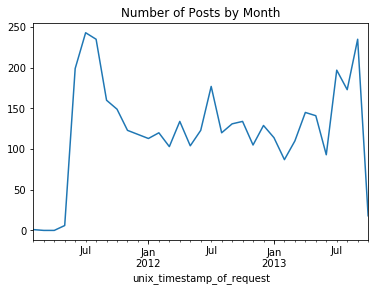

In [38]:
train_json_df['unix_timestamp_of_request'] = pd.to_datetime(train_json_df["unix_timestamp_of_request"], unit = 's')
train_json_df.index = train_json_df['unix_timestamp_of_request']
train_json_df['unix_timestamp_of_request'].resample('M').count().plot().set_title('Number of Posts by Month')

Peaks for requests seems to occur around July.

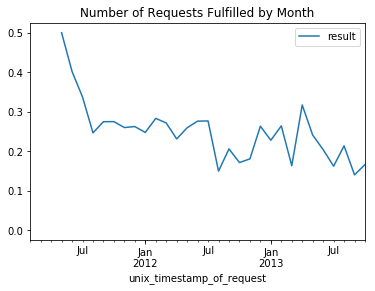

In [40]:
df = pd.DataFrame()
df['unix_timestamp_of_request'] = pd.to_datetime(train_json_df["unix_timestamp_of_request"], unit = 's')
df['result'] = train_json_df["requester_received_pizza"]
df.index = df['unix_timestamp_of_request']
df.resample('M').mean().plot().set_title('Number of Requests Fulfilled by Month')

No similar peak in terms of requests fulfilled.

#### Time of Day

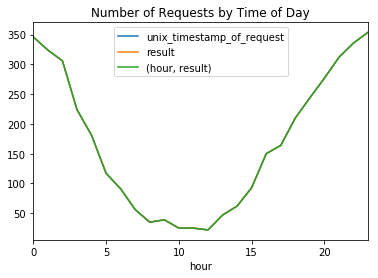

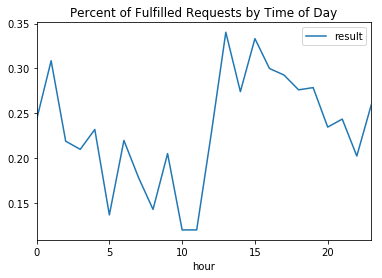

In [42]:
df['hour']=df['unix_timestamp_of_request'].dt.hour
df['hour', 'result'] = df.groupby('hour').count().plot().set_title('Number of Requests by Time of Day')
df['hour', 'result'] = df.groupby('hour').mean().plot().set_title('Percent of Fulfilled Requests by Time of Day')

In [ ]:
###Wordcloud Visualization

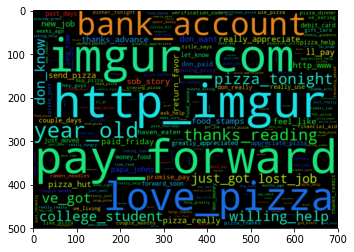

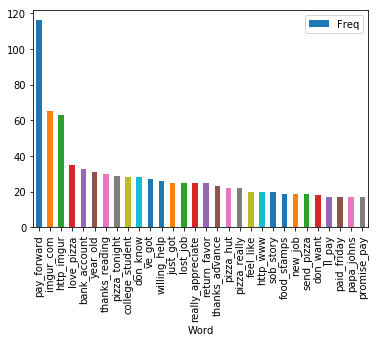

In [41]:
def word_join(string,joiner='_'):
    return joiner.join(string.split()) 
v_join=np.vectorize(word_join)

CV=CountVectorizer(stop_words='english',ngram_range=(2,2))
Ctbow=CV.fit_transform(train_data[train_labels==1])
vocab=v_join(CV.get_feature_names())
freqs=list(Ctbow.toarray().sum(axis=0))
word_score=list(zip(vocab,freqs))
word_score=sorted(word_score, key=lambda x: -x[1])
wc=WordCloud(max_words=200,height=500,width=700).fit_words(word_score)
plt.imshow(wc, interpolation='bilinear')
got_pizza=pd.DataFrame(word_score[:30],columns = ['Word', 'Freq'])
got_pizza.plot.bar(x='Word',y='Freq')


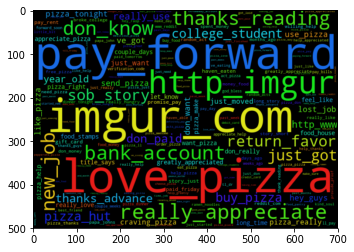

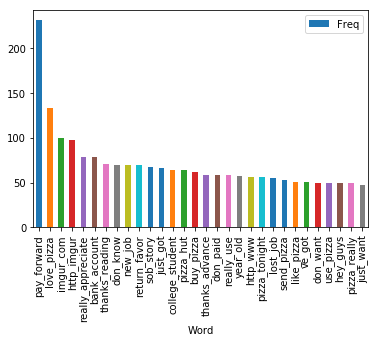

In [40]:
CV=CountVectorizer(stop_words='english',ngram_range=(2,2))
Ctbow=CV.fit_transform(train_data[train_labels==0])
vocab=v_join(CV.get_feature_names())
freqs=list(Ctbow.toarray().sum(axis=0))
word_score=list(zip(vocab,freqs))
word_score=sorted(word_score, key=lambda x: -x[1])
wc=WordCloud(max_words=200,height=500,width=700).fit_words(word_score)
plt.imshow(wc, interpolation='bilinear')
no_pizza=pd.DataFrame(word_score[:30],columns = ['Word', 'Freq'])
no_pizza.plot.bar(x='Word',y='Freq')

We chose bigrams as a balance in terms of unigrams alone made little sense and trigrams were too rare to make much use of. From these visuals we can start to get an idea of potential differentiatiors in terms of post content that might make a difference to wether a user gets pizza or not. There are some interesting differences such as Redditors getting the pizza talking about "lost job" vs those not saying "new job". Even amongst common phrases, what's interesting is how those who didn't get pizza mentioned "love pizza" and "pay forward" more often (indicators of disingenuity?).

## Step 2: Create a Baseline Model 

In [13]:
# use standard TfidfVectorizer to transform the training data and dev data 
vectorizer = CountVectorizer() #would suggest countvect since easier to interpret and justify...
train_bag_of_words = vectorizer.fit_transform(train_data)
dev_bag_of_words = vectorizer.transform(dev_data)

# create MultinomialNB
nb = MultinomialNB()
    
# test the best value for alpha
parameters = {'alpha': np.linspace(0.01, 10, 100)}

# create GridSearchCV to find the best alpha
clf = GridSearchCV(nb, parameters)
    
# train the MultinomialNB
clf.fit(train_bag_of_words, train_labels)

pred_dev_prob = clf.predict_proba(dev_bag_of_words)[:,0]

print(clf.best_params_)
print("auc score using CountVectorizer & MultinomialNB = {}".format(roc_auc_score(dev_labels, pred_dev_prob, average='micro')))


{'alpha': 8.385454545454545}
auc score using CountVectorizer & MultinomialNB = 0.5880349615375456


We use the Naive Bayes model combined with a tfidf bag of words approach as our baseline since tfidf will likely be our base going forward and Naive Bayes is the simplest modeling approach to take in terms of model assumptions and complexity. We see with an auc of .588, our baseline doesnt do much better than randomly guessing (auc of .5).